In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/deepfashion-inshop-clothes-retrieval-adjusted'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepfashion-inshop-clothes-retrieval-adjusted/images/1221_022.jpg
/kaggle/input/deepfashion-inshop-clothes-retrieval-adjusted/images/2333_022.jpg
/kaggle/input/deepfashion-inshop-clothes-retrieval-adjusted/images/2052_031.jpg
/kaggle/input/deepfashion-inshop-clothes-retrieval-adjusted/images/4810_011.jpg
/kaggle/input/deepfashion-inshop-clothes-retrieval-adjusted/images/4729_012.jpg
/kaggle/input/deepfashion-inshop-clothes-retrieval-adjusted/images/4415_012.jpg
/kaggle/input/deepfashion-inshop-clothes-retrieval-adjusted/images/1740_022.jpg
/kaggle/input/deepfashion-inshop-clothes-retrieval-adjusted/images/1607_051.jpg
/kaggle/input/deepfashion-inshop-clothes-retrieval-adjusted/images/1241_022.jpg
/kaggle/input/deepfashion-inshop-clothes-retrieval-adjusted/images/4171_042.jpg
/kaggle/input/deepfashion-inshop-clothes-retrieval-adjusted/images/3517_021.jpg
/kaggle/input/deepfashion-inshop-clothes-retrieval-adjusted/images/2560_031.jpg
/kaggle/input/deepfashion-inshop-clothes

In [9]:
DATA_ROOT = "/kaggle/input/deepfashion-inshop-clothes-retrieval-adjusted"
IMAGES_DIR = os.path.join(DATA_ROOT, "images")
MASK_DIR = os.path.join(DATA_ROOT, "masks")

In [18]:

import os
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import random

In [54]:

#  收集影像檔案並檢查完整性、影像-mask 配對

all_images = sorted(os.listdir(IMAGES_DIR))
valid_images = []

print(" 資料清洗中：檢查檔案完整性與 mask 配對...")
for img_file in tqdm(all_images):
    img_path = os.path.join(IMAGES_DIR, img_file)
    mask_path = os.path.join(MASK_DIR, img_file.replace(".jpg",".png"))

    try:
        # 檢查影像是否可讀
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        
        # 影像尺寸檢查
        if img.width < 32 or img.height < 32:
            continue  # 過小影像過濾

        # 空白影像檢查（平均像素值過低或過高）
        img_array = np.array(img)
        if img_array.mean() < 5 or img_array.mean() > 250:
            continue

        # 遮罩標籤檢查
        mask_array = np.array(mask)
        if mask_array.max() > 255 or mask_array.min() < 0:
            continue

        valid_images.append(img_file)
    except:
        continue

print(f" 有效影像數量: {len(valid_images)} / {len(all_images)}")


 資料清洗中：檢查檔案完整性與 mask 配對...


100%|██████████| 13752/13752 [03:50<00:00, 59.55it/s]

 有效影像數量: 13752 / 13752


In [58]:
# 自動生成 item_id 與 labels

item_to_idx = {}
labels = []

for f in valid_images:
    item_id = f.split("_")[0]  # 假設檔名前綴為衣服編號
    if item_id not in item_to_idx:
        item_to_idx[item_id] = len(item_to_idx)
    labels.append(item_to_idx[item_id])

num_classes = len(item_to_idx)
print(f" 共 {num_classes} 個服飾類別")

 共 4599 個服飾類別


In [59]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)


各類別樣本數： Counter({903: 77, 1661: 59, 1671: 58, 877: 56, 2217: 52, 4466: 45, 1669: 38, 4112: 38, 1734: 37, 3839: 34, 4238: 34, 4294: 34, 4576: 34, 4099: 31, 3474: 30, 1441: 27, 981: 26, 1779: 26, 116: 25, 1446: 25, 2337: 25, 1459: 24, 4084: 22, 4381: 22, 460: 21, 1229: 21, 1608: 21, 2475: 21, 4431: 20, 3222: 19, 893: 18, 1133: 18, 1678: 18, 2654: 18, 4134: 18, 590: 17, 735: 17, 2712: 17, 367: 16, 515: 16, 4286: 16, 581: 15, 1673: 15, 1902: 15, 3953: 15, 244: 14, 698: 14, 857: 14, 1435: 14, 1826: 14, 1858: 14, 2391: 14, 3512: 14, 4429: 14, 4478: 14, 1616: 13, 2139: 13, 2707: 13, 3274: 13, 3836: 13, 4128: 13, 4597: 13, 504: 12, 3022: 12, 3436: 12, 3509: 12, 3536: 12, 4115: 12, 4394: 12, 383: 11, 624: 11, 653: 11, 890: 11, 1031: 11, 1096: 11, 1434: 11, 1506: 11, 2035: 11, 2179: 11, 2492: 11, 2626: 11, 3267: 11, 3600: 11, 4035: 11, 57: 10, 202: 10, 325: 10, 382: 10, 1181: 10, 1286: 10, 1496: 10, 1880: 10, 2049: 10, 2769: 10, 2786: 10, 2867: 10, 2983: 10, 3130: 10, 3279: 10, 3372: 10, 3404: 1

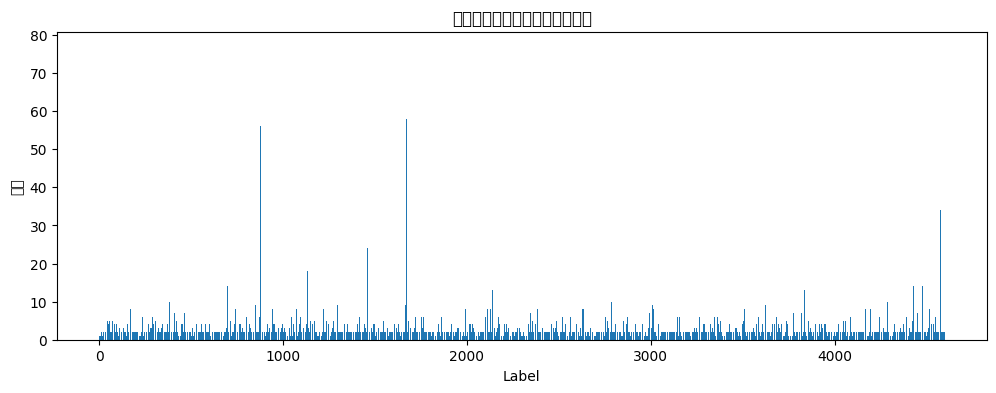

In [69]:
# 4️⃣ 標籤分析與統計
# ===============================
label_counts = Counter(labels)
print("各類別樣本數：", label_counts)

# 類別分布視覺化
plt.figure(figsize=(12,4))
plt.bar(label_counts.keys(), label_counts.values())
plt.title("各服飾類別樣本分布（複製後）")
plt.xlabel("Label")
plt.ylabel("數量")
plt.show()

In [72]:
# 4️⃣ Dataset class
# ===============================
class DeepFashionRetrievalDataset(Dataset):
    def __init__(self, image_files, images_dir, labels, transform=None, use_mask=False, masks_dir=None):
        self.image_files = image_files
        self.images_dir = images_dir
        self.labels = labels
        self.transform = transform
        self.use_mask = use_mask
        self.masks_dir = masks_dir

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        label = self.labels[idx]

        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        # optional: 使用 mask 去掉背景
        if self.use_mask and self.masks_dir is not None:
            mask_path = os.path.join(self.masks_dir, img_name.replace(".jpg",".png"))
            if os.path.exists(mask_path):
                mask = Image.open(mask_path).convert("L")
                image_np = np.array(image)
                mask_np = np.array(mask) > 0
                image_np[~mask_np] = 0
                image = Image.fromarray(image_np)

        if self.transform:
            image = self.transform(image)

        return image, label


In [73]:
# 5️⃣ Transforms (資料增強)
# ===============================
image_transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.RandomResizedCrop(512, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

mask_transform = transforms.Compose([
    transforms.Resize((512,512), interpolation=Image.NEAREST),
    transforms.ToTensor()
])


In [74]:
# 6️⃣ 建立 Dataset
# ===============================
dataset = DeepFashionRetrievalDataset(valid_images, IMAGES_DIR, labels,
                                     transform=image_transform,
                                     use_mask=False,
                                     masks_dir=MASK_DIR)

In [75]:
# 7️⃣ train / val / test 分割 (同 item_id 不可跨 split)
# ===============================
# 先建立 item_id 對應索引
item_to_indices = {}
for idx, f in enumerate(valid_images):
    item_id = f.split("_")[0]
    if item_id not in item_to_indices:
        item_to_indices[item_id] = []
    item_to_indices[item_id].append(idx)

train_idx, val_idx, test_idx = [], [], []

item_ids = list(item_to_indices.keys())
random.shuffle(item_ids)

train_cut = int(len(item_ids)*0.85)
val_cut = int(len(item_ids)*0.95)

for i, item_id in enumerate(item_ids):
    idxs = item_to_indices[item_id]
    if i < train_cut:
        train_idx.extend(idxs)
    elif i < val_cut:
        val_idx.extend(idxs)
    else:
        test_idx.extend(idxs)

train_set = Subset(dataset, train_idx)
val_set   = Subset(dataset, val_idx)
test_set  = Subset(dataset, test_idx)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")


Train: 11626, Val: 1457, Test: 656


In [76]:
from torch.utils.data import Subset, WeightedRandomSampler
# 8️⃣ WeightedRandomSampler 處理資料不平衡
# ===============================
train_labels = [labels[i] for i in train_idx]
class_sample_count = np.bincount(train_labels)
class_sample_count[class_sample_count==0] = 1
weights = 1.0 / class_sample_count
sample_weights = np.array([weights[l] for l in train_labels])
sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)


In [66]:
# 9️⃣ DataLoader
# ===============================
train_loader = DataLoader(train_set, batch_size=32, sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)


In [77]:
# 10️⃣ 範例 batch
# ===============================
images, labels_batch = next(iter(train_loader))
print(f"Images batch shape: {images.shape}")
print(f"Labels batch: {labels_batch[:10]}")

Images batch shape: torch.Size([32, 3, 512, 512])
Labels batch: tensor([1649, 4506, 2479, 3447, 3939, 1621,  379, 3956, 3300,  713])


In [78]:
import os
import shutil

# Kaggle working 目錄
OUTPUT_DIR = "/kaggle/working/dataset_split"
TRAIN_DIR = os.path.join(OUTPUT_DIR, "train", "images")
VAL_DIR   = os.path.join(OUTPUT_DIR, "val", "images")
TEST_DIR  = os.path.join(OUTPUT_DIR, "test", "images")

# 建立目錄
for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(d, exist_ok=True)

# 複製影像函數
def copy_images(indices, dest_dir, image_files, images_dir):
    for idx in indices:
        src_path = os.path.join(images_dir, image_files[idx])
        dst_path = os.path.join(dest_dir, image_files[idx])
        shutil.copy(src_path, dst_path)

# 複製 train/val/test
copy_images(train_idx, TRAIN_DIR, valid_images, IMAGES_DIR)
copy_images(val_idx, VAL_DIR, valid_images, IMAGES_DIR)
copy_images(test_idx, TEST_DIR, valid_images, IMAGES_DIR)

print("✅ 影像已複製完成，輸出目錄：", OUTPUT_DIR)


✅ 影像已複製完成，輸出目錄： /kaggle/working/dataset_split


In [ ]:
import shutil

shutil.make_archive("/kaggle/working/dataset_split", 'zip', "/kaggle/working/dataset_split")
print("✅ 已打包成 /kaggle/working/dataset_split.zip，可從 Output 下載")
